# Calculating pixel counts above and below the center line of the image

**Methods:**
>1. Load data
>2. Write a function that calculates the center line of the number
>3. Plot the numbers with the center line drawn to confirm it's working
>4. Calculate the pixel count above and below the center line for each number
>5. Show a scatter plot of their above and below pixel count, hued by the number

* There is a clear separation between 1s and 7s

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.svm as skl_svm
import sklearn.cross_validation as skl_cv
import seaborn as sns
sns.set_context(context = 'notebook', font_scale=1.5)
import os
import sys
import cv2

base_path = '/home/lundi/Python/MNIST/'
sys.path.append(base_path + '/libraries/')

import MNIST_data_processor as mdp

MNIST_data_processor = mdp.MNIST_data_processor()

from matplotlib.patches import Ellipse

## 1. Load data

In [2]:
X, y = MNIST_data_processor.load_subset_data()

## 2. Write a function that calculates the center line of the number

In [26]:
def calculate_center_of_number(digit_data):
    digit_data_reshape = pd.DataFrame(digit_data.reshape(28,28))
    pixel_indexes = digit_data_reshape.max(axis=1).replace(0, np.nan).dropna()
    #print pixel_indexes
    mid_index = int(1.0 * pixel_indexes.shape[0] / 2.0)
    return pixel_indexes.index[mid_index]
     

In [27]:
calculate_center_of_number(X.ix[0])

14

## 3. Plot the numbers with the center line drawn to confirm it's working

In [28]:
def convert_to_image(data):
    img = np.zeros((28, 28,3))
    img[:,:,0] = data.reshape(28,28)
    img[:,:,1] = data.reshape(28,28)
    img[:,:,2] = data.reshape(28,28)
    
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img

def get_ellipse(digit_data):
    image = convert_to_image(digit_data)
    
    ret,thresh = cv2.threshold(image,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)

    valid_contours = []
    #Get the valid contours
    for cnt in contours:
        if len(cnt) >= 5:
            valid_contours.append(cnt)
    return valid_contours

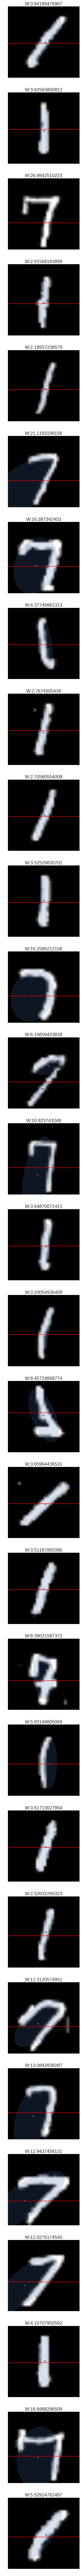

In [29]:
number_indexes = np.bitwise_or( (y == 1),  (y == 7) )
X_subset = X.loc[number_indexes].head(30)

plt.figure(figsize=(5, 6 * X_subset.shape[0]))
counter = 0
for index, current_digit_data in X_subset.iterrows():
    valid_contours = get_ellipse(current_digit_data)
    plt.subplot(X_subset.shape[0], 1, (counter+1))
    counter+=1

    image = convert_to_image(current_digit_data)
    # ensure at least some circles were found
    
    for cnt in valid_contours:
        ellipse = cv2.fitEllipse(cnt)
        #print 'xy', ellipse[0]
        #print 'area:', ellipse[1][0] * ellipse[1][1] * np.pi
        #print 'W:', ellipse[1][0]
        #print 'H:', ellipse[1][1]
        ellipse_matplot = Ellipse(xy=ellipse[0], width=ellipse[1][0], height=ellipse[1][1], angle=ellipse[2])
        ax = plt.gca()
        ax.add_artist(ellipse_matplot)
        ellipse_matplot.set_clip_box(ax.bbox)
        ellipse_matplot.set_alpha(0.2)

        ellipse_matplot = Ellipse(xy=ellipse[0], width=0.6, height=0.6, angle=0)
        ax.add_artist(ellipse_matplot)
        ellipse_matplot.set_clip_box(ax.bbox)

        
        
        

        ax.axis('off')
    plt.imshow(255 - image)
    mid_line = calculate_center_of_number(current_digit_data)
    
    top_pixels, bottom_pixels = get_pixels_above_and_below(current_digit_data, mid_line)
    
    ax.set_title('Top:' + str(top_pixels))
    ax.axhline(mid_line, c='r')

## 4. Calculate the pixel count above and below the center line for each number

In [42]:
def get_pixels_above_and_below(digit_data, mid_line):
    digit_data_reshape = pd.DataFrame(digit_data.reshape(28,28))
    top_region = digit_data_reshape.ix[0:mid_line-1]
    bottom_region = digit_data_reshape.ix[mid_line:]
    
    return top_region.sum().sum(), bottom_region.sum().sum()

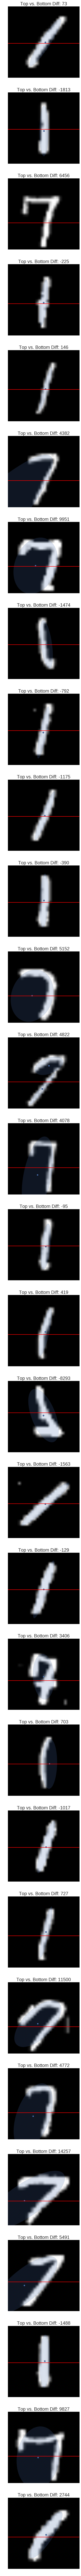

In [40]:
number_indexes = np.bitwise_or( (y == 1),  (y == 7) )
X_subset = X.loc[number_indexes].head(30)

plt.figure(figsize=(5, 6 * X_subset.shape[0]))
counter = 0
for index, current_digit_data in X_subset.iterrows():
    valid_contours = get_ellipse(current_digit_data)
    plt.subplot(X_subset.shape[0], 1, (counter+1))
    counter+=1

    image = convert_to_image(current_digit_data)
    # ensure at least some circles were found
    
    for cnt in valid_contours:
        ellipse = cv2.fitEllipse(cnt)
        #print 'xy', ellipse[0]
        #print 'area:', ellipse[1][0] * ellipse[1][1] * np.pi
        #print 'W:', ellipse[1][0]
        #print 'H:', ellipse[1][1]
        ellipse_matplot = Ellipse(xy=ellipse[0], width=ellipse[1][0], height=ellipse[1][1], angle=ellipse[2])
        ax = plt.gca()
        ax.add_artist(ellipse_matplot)
        ellipse_matplot.set_clip_box(ax.bbox)
        ellipse_matplot.set_alpha(0.2)

        ellipse_matplot = Ellipse(xy=ellipse[0], width=0.6, height=0.6, angle=0)
        ax.add_artist(ellipse_matplot)
        ellipse_matplot.set_clip_box(ax.bbox)

        
        
        

        ax.axis('off')
    plt.imshow(255 - image)
    mid_line = calculate_center_of_number(current_digit_data)
    
    top_pixels, bottom_pixels = get_pixels_above_and_below(current_digit_data, mid_line)
    
    ax.set_title('Top vs. Bottom Diff: ' + str(top_pixels - bottom_pixels))
    ax.axhline(mid_line, c='r')

This demonstrates that 7s have a much higher pixel count on top vs. on bottom

## 5. Show a scatter plot of their above and below pixel count, hued by the number

In [43]:
results = []
for index, current_digit_data in X.iterrows():
    mid_line = calculate_center_of_number(current_digit_data)
    top_pixels, bottom_pixels = get_pixels_above_and_below(current_digit_data, mid_line)
    results.append([y[index], top_pixels, bottom_pixels])

In [46]:
results_df = pd.DataFrame(results, columns = ['label', 'top','bottom'])

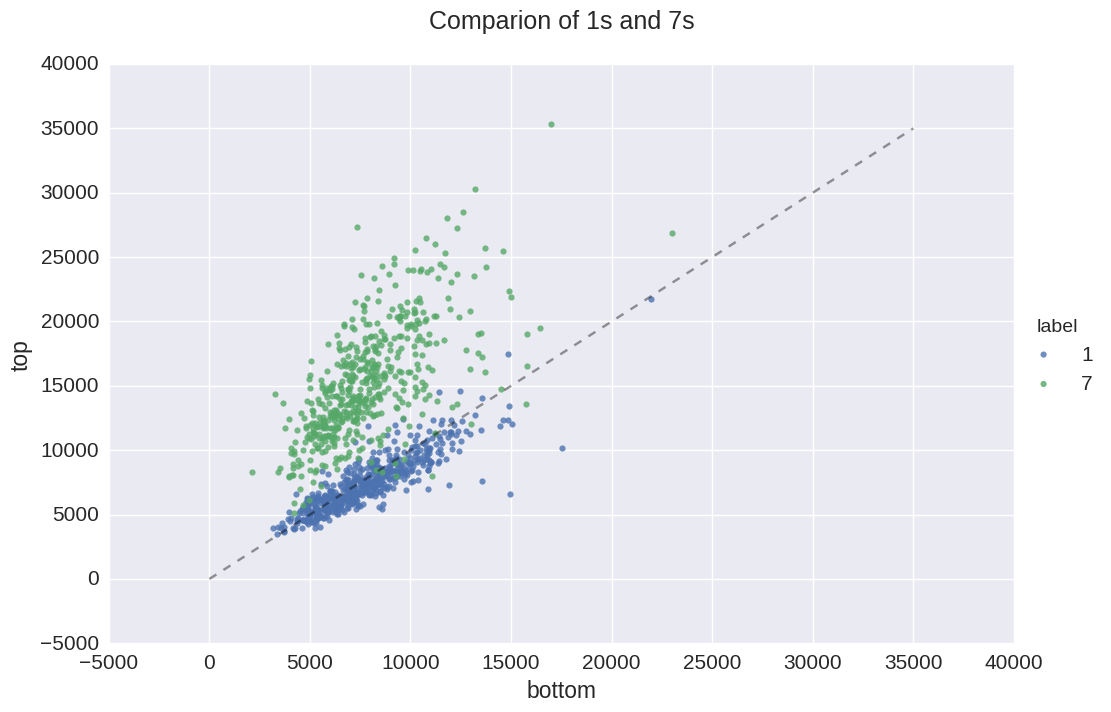

In [82]:
sns.lmplot(x = 'bottom', y = 'top', data = results_df.loc[results_df['label'].isin([1,7])], hue='label', fit_reg=False, ci=95, size=7, aspect = 1.5)
plt.plot([0,35000], [0, 35000], 'k--', alpha = 0.4)
ax = plt.gca()
ax.set_title('Comparion of 1s and 7s', y=1.05)

#### This shows a clear separation between 1s and 7s

Looking for other separations

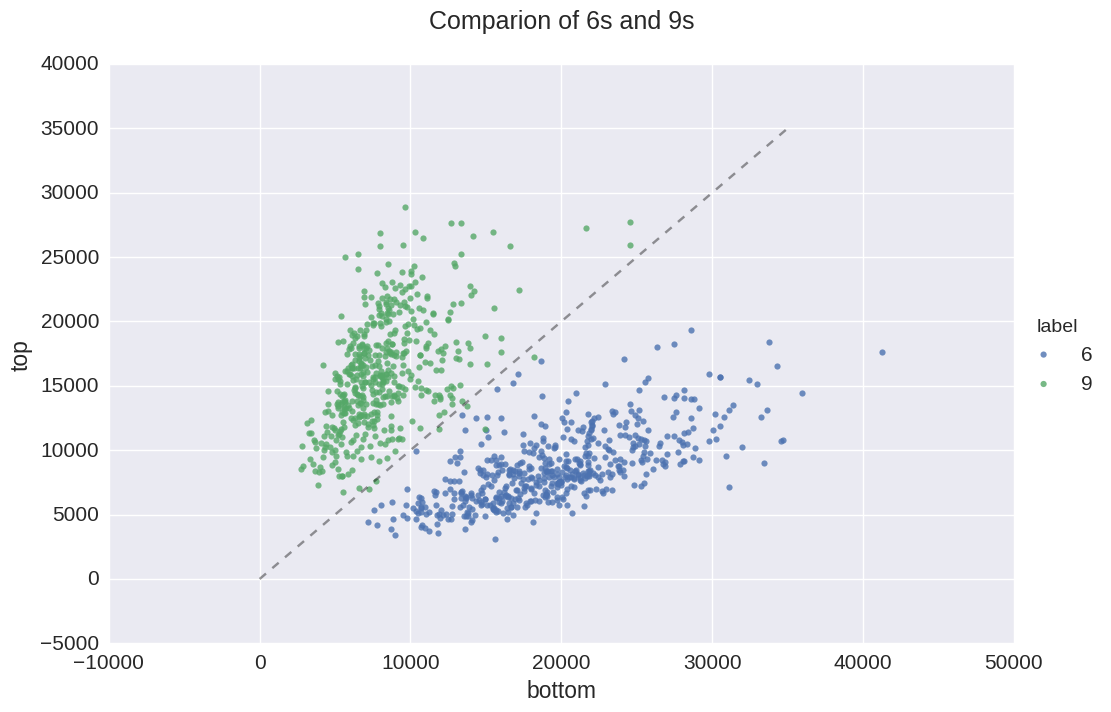

In [80]:
sns.lmplot(x = 'bottom', y = 'top', data = results_df.loc[results_df['label'].isin([6,9])], hue='label', fit_reg=False, ci=95, size=7, aspect = 1.5)
plt.plot([0,35000], [0, 35000], 'k--', alpha = 0.4)
ax = plt.gca()
ax.set_title('Comparion of 6s and 9s', y=1.05)

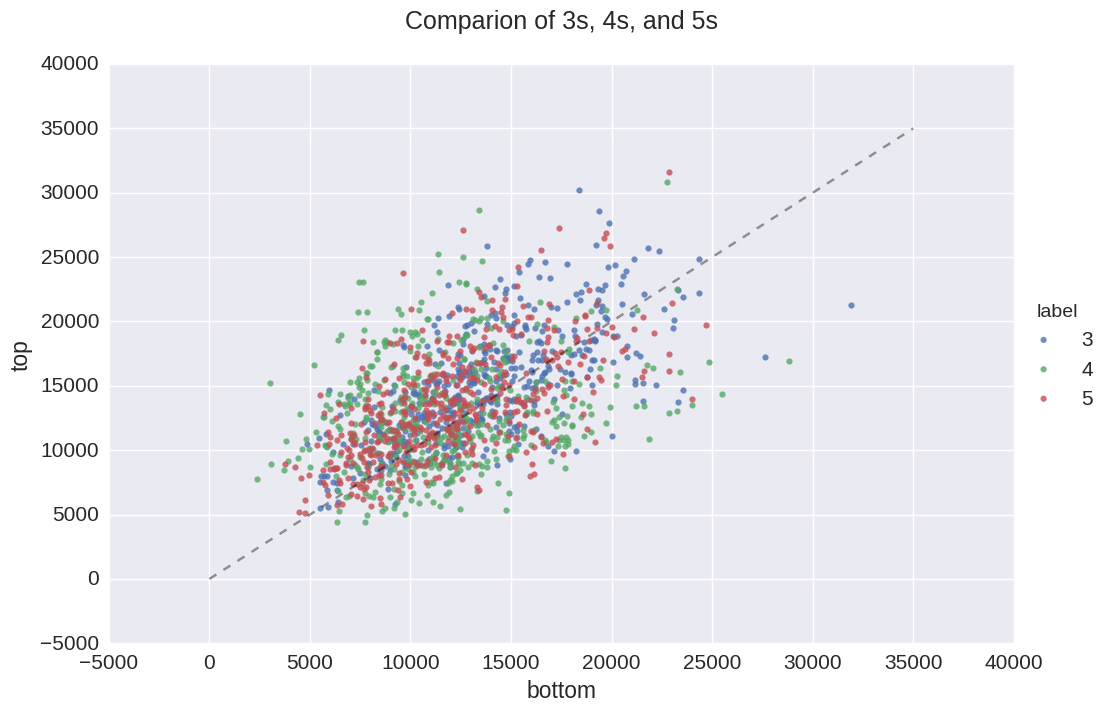

In [89]:
sns.lmplot(x = 'bottom', y = 'top', data = results_df.loc[results_df['label'].isin([3,4,5])], hue='label', fit_reg=False, ci=95, size=7, aspect = 1.5)
plt.plot([0,35000], [0, 35000], 'k--', alpha = 0.4)
ax = plt.gca()
ax.set_title('Comparion of 3s, 4s, and 5s', y=1.05)

3s, 4s, and 5s are pretty screwed with this measurement